# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
n_k1 = 8
n_k2 = 2

p1 = n_k1 / (n_k1 + n_k2)
p2 = n_k2 / (n_k1 + n_k2)
entropy = - (p1 * np.log(p1) + p2 * np.log(p2))
entropy

0.5004024235381879

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [5]:
l_p1 = 1
l_p2 = 0
r_p1 = 0
r_p2 = 1

def h(n_k1: int, n_k2: int):
    p1 = n_k1 / (n_k1 + n_k2)
    p2 = n_k2 / (n_k1 + n_k2)
    
    return p1 * (1 - p1) + p2 * (1 - p2)

Q = h(8, 2) - (2 / 10) * h(10, 0) - (8 / 10) * h(0, 10) 
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [7]:
arr = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

np.sum(arr) / np.size(arr)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [10]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [11]:
def gini_impurity(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    prob_sq_sum = np.sum((counts / len(y)) ** 2)
    return 1 - prob_sq_sum

def variance(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0
    return np.var(y)

In [13]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    X = np.asarray(feature_vector)
    y = np.asarray(target_vector)

    if feature_type == "real":
        sorted_idx = np.argsort(X)
        X_sorted = X[sorted_idx]
        y_sorted = y[sorted_idx]
        
        t = (X_sorted[:-1] + X_sorted[1:]) / 2
        mask = X_sorted[1:] != X_sorted[:-1]
        t = t[mask]
        n = len(y_sorted)
        
        if task == "classification":
            left_counts = np.cumsum(pd.get_dummies(y_sorted).values, axis=0)[:-1]
            right_counts = np.sum(pd.get_dummies(y_sorted).values, axis=0) - left_counts
            left_size = np.arange(1, n)
            right_size = n - left_size[:, np.newaxis]

            left_probs = left_counts / left_size[:, np.newaxis]
            right_probs = right_counts / right_size

            gini_left = 1 - np.sum(left_probs ** 2, axis=1)
            gini_right = 1 - np.sum(right_probs ** 2, axis=1)

            w_left = left_size / n
            w_right = 1 - w_left

            ginis = w_left * gini_left + w_right * gini_right
            ginis = ginis[mask]

        elif task == "regression":
            cumsum_y = np.cumsum(y_sorted)
            cumsum_y2 = np.cumsum(y_sorted ** 2)

            left_count = np.arange(1, n)
            right_count = n - left_count

            left_sum = cumsum_y[:-1]
            left_sum_sq = cumsum_y2[:-1]
            right_sum = cumsum_y[-1] - left_sum
            right_sum_sq = cumsum_y2[-1] - left_sum_sq

            left_var = (left_sum_sq / left_count) - (left_sum / left_count) ** 2
            right_var = (right_sum_sq / right_count) - (right_sum / right_count) ** 2

            w_left = left_count / n
            w_right = 1 - w_left

            ginis = w_left * left_var + w_right * right_var
            ginis = ginis[mask]

        best_idx = np.argmin(ginis)
        return t, ginis, t[best_idx], ginis[best_idx]


    elif feature_type == "categorical":
        values = np.unique(X)
        t = []
        ginis = []

        for val in values:
            left_mask = X == val
            right_mask = ~left_mask

            y_left = y[left_mask]
            y_right = y[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            if task == "classification":
                g_left = gini_impurity(y_left)
                g_right = gini_impurity(y_right)
            else:
                g_left = variance(y_left)
                g_right = variance(y_right)

            w_left = len(y_left) / len(y)
            w_right = 1 - w_left
            score = w_left * g_left + w_right * g_right

            t.append(val)
            ginis.append(score)

        ginis = np.array(ginis)
        t = np.array(t)
        best_idx = np.argmin(ginis)
        return t, ginis, t[best_idx], ginis[best_idx]


Эту функцию можно протестировать на датасете `California`.

In [14]:
from sklearn.datasets import fetch_california_housing

In [15]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [16]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

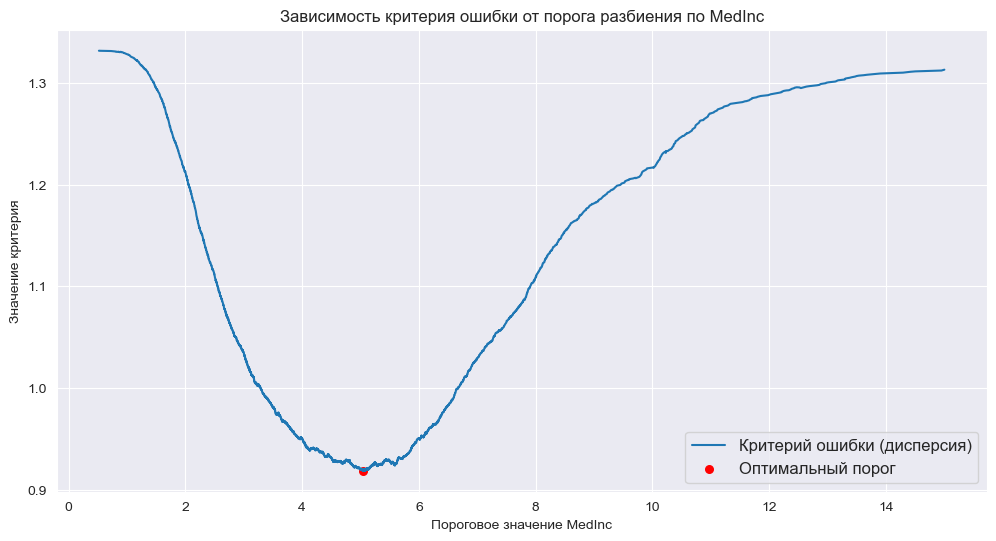

In [19]:
feature = X['MedInc']
target = y

t, ginis, threshold_best, gini_best = find_best_split(feature_vector=feature,target_vector=target,task="regression", feature_type="real")

plt.figure(figsize=(12, 6))
plt.plot(t, ginis, label="Критерий ошибки (дисперсия)")
plt.xlabel("Пороговое значение MedInc")
plt.ylabel("Значение критерия")
plt.title("Зависимость критерия ошибки от порога разбиения по MedInc")

plt.scatter(threshold_best, gini_best, color='red', s=30, label=f'Оптимальный порог')
plt.legend(fontsize=12)

plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [23]:
best_feature = None
best_threshold = None
best_score = np.inf

for feature in X.columns:
    thresholds, scores, thresh, score = find_best_split(
        feature_vector=X[feature].values,
        target_vector=y,
        task="regression",
        feature_type="real"
    )

    if len(scores) > 0 and score < best_score:
        best_score = score
        best_threshold = thresh
        best_feature = feature

print(f"Лучший признак: {best_feature}")
print(f"Лучший порог разбиения: {best_threshold:.4f}")
print(f"Значение дисперсии: {best_score:.4f}")

Лучший признак: MedInc
Лучший порог разбиения: 5.0351
Значение дисперсии: 0.9188


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [97]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
            self,
            sub_X: np.ndarray,
            sub_y: np.ndarray,
            node: dict
    ) -> None:

        if len(sub_y) == 0:
            node["type"] = "terminal"
            node["class"] = None
            return
    
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
    
        feature_best, threshold_best, gini_best, split = None, None, None, None
    
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
    
            feature_vector = sub_X[:, feature]
    
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
    
            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini
    
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold
    
        if feature_best is None or split.sum() == 0 or (~split).sum() == 0:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
    
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
    
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
    
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """

        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        feature_type = self._feature_types[feature]

        if np.isnan(x[feature]):
            return self._predict_node(x, node["left_child"])

        if feature_type == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

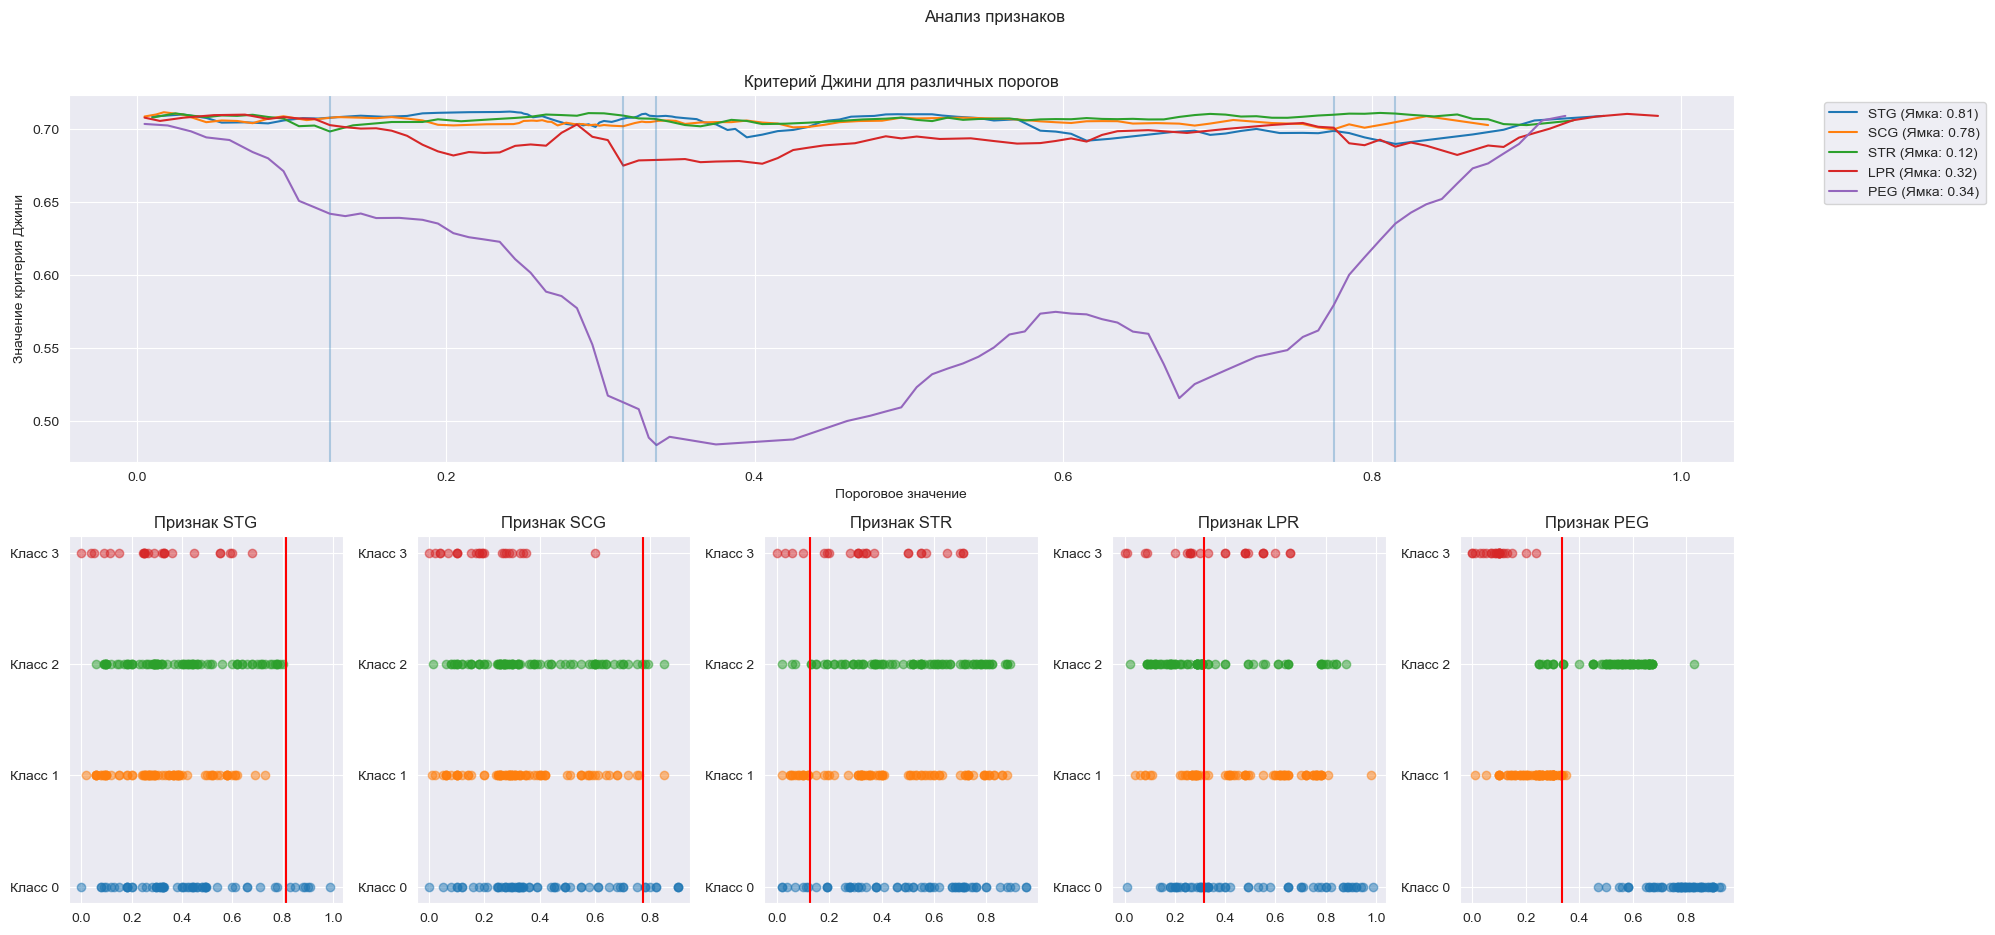

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelEncoder

data = pd.read_excel('Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls', sheet_name=1)
data.columns = data.columns.str.strip()

feature_columns = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
target_column = 'UNS'

for col in feature_columns:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

target_le = LabelEncoder()
data[target_column] = target_le.fit_transform(data[target_column])

X = data[feature_columns].values.astype(float)
y = data[target_column].values.astype(int)

plt.figure(figsize=(20, 10))
plt.suptitle('Анализ признаков', y=1.02)
gs = GridSpec(3, 5, height_ratios=[1, 1, 0.1])

ax_gini = plt.subplot(gs[0, :])
ax_gini.set_title('Критерий Джини для различных порогов')
ax_gini.set_xlabel('Пороговое значение')
ax_gini.set_ylabel('Значение критерия Джини')

axes_scatter = [plt.subplot(gs[1, i]) for i in range(len(feature_columns))]

for i, (name, ax) in enumerate(zip(feature_columns, axes_scatter)):
    feature = X[:, i]
    thresholds, ginis, best_thresh, best_gini = find_best_split(
        feature_vector=feature,
        target_vector=y,
        task="classification",
        feature_type="real"
    )
    
    # Кривая Джини
    ax_gini.plot(thresholds, ginis, label=f'{name} (Ямка: {best_thresh:.2f})')
    ax_gini.axvline(best_thresh, alpha=0.3)

    # Диаграмма рассеяния
    for class_val in np.unique(y):
        mask = (y == class_val)
        ax.scatter(feature[mask], np.full_like(feature[mask], class_val),
                   alpha=0.5, label=f'Class {class_val}')

    ax.axvline(best_thresh, color='red')
    ax.set_title(f'Признак {name}')
    ax.set_yticks(np.unique(y))
    ax.set_yticklabels([f'Класс {val}' for val in np.unique(y)])
    ax.grid(True)

ax_gini.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_gini.grid(True)
plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [99]:
# Стоит проводить разделение по признаку PEG — это согласуется с визуальной оценкой диаграммы рассеяния. Хорошие кривые имеют явные впадины.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (находится в директории с ноутбуком), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [103]:
from sklearn.metrics import accuracy_score

data = pd.read_csv('agaricus-lepiota.data')

le = LabelEncoder()
encoded_data = data.apply(lambda col: le.fit_transform(col))

X = encoded_data.iloc[:, 1:].values
y = encoded_data.iloc[:, 0].values

np.random.seed(42)
indices = np.random.permutation(len(X))
split_idx = len(X) // 2

X_train, y_train = X[indices[:split_idx]], y[indices[:split_idx]]
X_test, y_test = X[indices[split_idx:]], y[indices[split_idx:]]

feature_types = ['categorical'] * (X.shape[1])
tree = DecisionTree(feature_types=feature_types, task="classification")
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy на тестовой выборке: {accuracy:.4f}")

Accuracy на тестовой выборке: 0.9990


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [104]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [105]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

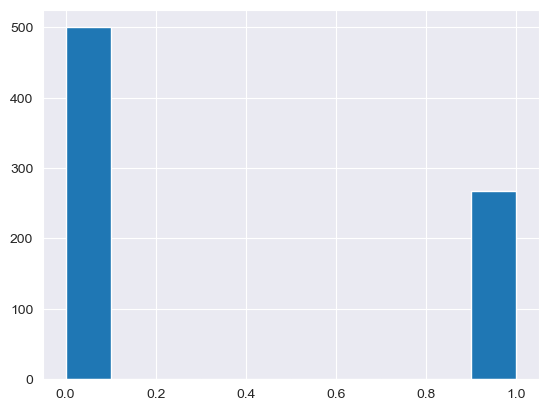

In [106]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [110]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [114]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from collections import Counter

max_depth_list = [3, 5, 7, 10]
min_samples_leaf_list = [1, 5, 10, 20, 50]

best_f1 = -1
best_params = {}

for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        tree = DecisionTree(
            feature_types=['categorical']*X.shape[1],
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            task="classification"
        )
        tree.fit(X_train_train, y_train_train)

        y_val_pred = tree.predict(X_train_val)

        current_f1 = f1_score(y_train_val, y_val_pred)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf
            }

print(f"Лучшие параметры: {best_params} с F1-мерой: {best_f1:.4f}")

final_tree = DecisionTree(
    feature_types=['categorical']*X.shape[1],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    task="classification"
)
final_tree.fit(X_train, y_train) 

y_test_pred = final_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred)

print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"auc_roc: {auc_roc:.4f}")

Лучшие параметры: {'max_depth': 3, 'min_samples_leaf': 1} с F1-мерой: 0.3564
accuracy: 0.6623
precision: 0.5283
recall: 0.3457
auc_roc: 0.5895


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [115]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

base_tree = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

bagging = BaggingClassifier(
    base_estimator=base_tree,
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bagging.fit(X_train, y_train)

y_test_pred = bagging.predict(X_test)
y_test_proba = bagging.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-score': f1_score(y_test, y_test_pred),
    'AUC-ROC': roc_auc_score(y_test, y_test_proba)
}

print(metrics)

/opt/miniconda3/envs/omo/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'Accuracy': 0.7316017316017316, 'Precision': 0.6610169491525424, 'Recall': 0.48148148148148145, 'F1-score': 0.5571428571428572, 'AUC-ROC': 0.8306995884773662}


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

max_depth_values = [5, 10, 15, 20, None]
min_samples_split_values = [2, 5, 10, 20]
cv_folds = 5

best_score = -1
best_params = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )

        scores = cross_val_score(rf, X_train, y_train,
                                 cv=cv_folds, scoring='f1')
        mean_score = np.mean(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_params = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split
            }

print(f"Лучшие параметры: {best_params}")
print(f"Средняя F1-мера при кросс-валидации: {best_score:.4f}")

final_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)

y_pred = final_rf.predict(X_test)
y_proba = final_rf.predict_proba(X_test)[:, 1]

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'F1-score': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba)
}
print(metrics)

Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5}
Средняя F1-мера при кросс-валидации: 0.6321
{'accuracy': 0.7575757575757576, 'precision': 0.6865671641791045, 'recall': 0.5679012345679012, 'F1-score': 0.6216216216216215, 'roc_auc': 0.8269958847736626}


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators:   1 | AUC-ROC: 0.6830
n_estimators:   5 | AUC-ROC: 0.7358
n_estimators:  10 | AUC-ROC: 0.7851
n_estimators:  20 | AUC-ROC: 0.8209
n_estimators:  30 | AUC-ROC: 0.8192
n_estimators:  40 | AUC-ROC: 0.8240
n_estimators:  50 | AUC-ROC: 0.8270
n_estimators:  75 | AUC-ROC: 0.8309
n_estimators: 100 | AUC-ROC: 0.8328
n_estimators: 150 | AUC-ROC: 0.8330
n_estimators: 200 | AUC-ROC: 0.8330


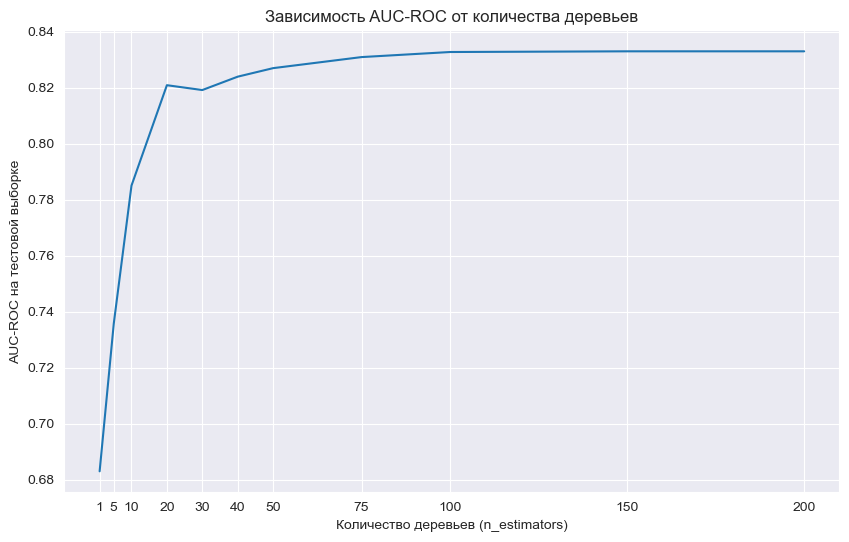

Лучшее количество деревьев: 150
Максимальное значение AUC-ROC: 0.8330


In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

n_estimators_range = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]
auc_scores = []

best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']

for n in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_max_depth,
        min_samples_split=best_min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)
    print(f"n_estimators: {n:3d} | AUC-ROC: {auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores)
plt.title('Зависимость AUC-ROC от количества деревьев')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('AUC-ROC на тестовой выборке')
plt.xticks(n_estimators_range)
plt.show()

optimal_n = n_estimators_range[np.argmax(auc_scores)]
print(f"Лучшее количество деревьев: {optimal_n}")
print(f"Максимальное значение AUC-ROC: {max(auc_scores):.4f}")

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

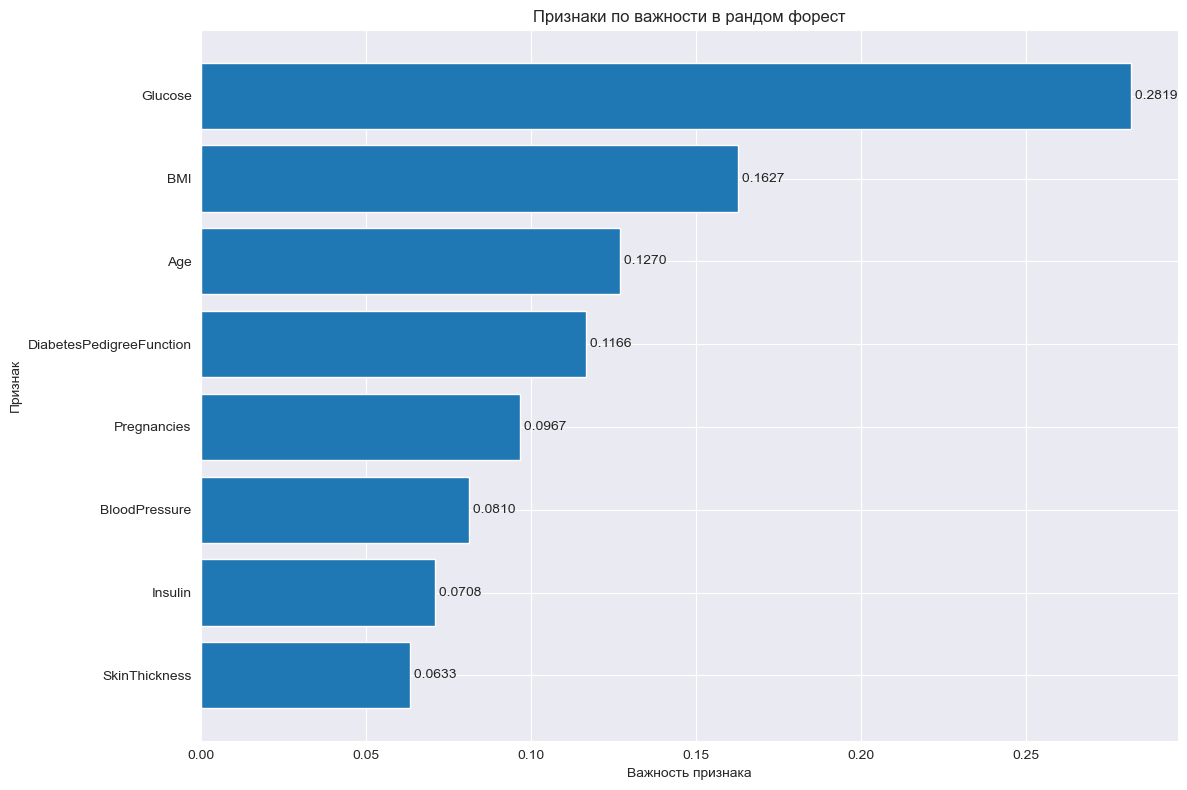

In [122]:
feature_importances = final_rf.feature_importances_

data.drop('Outcome', axis = 1)
features_df = pd.DataFrame({
    'Feature': [col for col in data.columns if col != 'Outcome'],
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Признаки по важности в рандом форест')
plt.xlabel('Важность признака')
plt.ylabel('Признак')

for index, value in enumerate(features_df['Importance']):
    plt.text(value, index, f' {value:.4f}', va='center')

plt.tight_layout()
plt.show()